In [16]:
# Importo le librerie
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [17]:
# 1. Caricamento del dataset
result = pyreadr.read_r("../Data/dataset_final.rds")
data = result[None]

# Seleziono le feature e la variabile target
selected_columns = ['neur', 'lymr', 'monor', 'crea', 'age', 'bun', 'crp', 'wbc']  # METTERE QUI I NOMI DELLE COLONNE DA INCLUDERE
features = data[selected_columns]
target = data['bacteremia']

# Normalizzo le feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Divido il dataset: training set (solo classe 0) e test set (tutti i dati)
X_train = X_scaled[target == 0]  # Addestriamo l'autoencoder solo con classe 0
X_test = X_scaled  # Usiamo tutti i dati per il test
y_test = target

In [18]:
# 2. Costruzione dell'autoencoder
input_dim = X_train.shape[1]  # Numero di feature

# # Definisco la rete neurale
# input_layer = Input(shape=(input_dim,))
# encoded = Dense(8, activation='relu')(input_layer)   # Primo livello nascosto
# encoded = Dense(4, activation='relu')(encoded)       # Bottleneck (compressione)
# decoded = Dense(8, activation='relu')(encoded)       # Primo livello di decodifica
# decoded = Dense(input_dim, activation='linear')(decoded)  # Output layer

# # Creo il modello autoencoder
# autoencoder = Model(inputs=input_layer, outputs=decoded)

# # Compilo il modello
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


# PROVO UN'ARCHITETTURA PIU' COMPLESSA:

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu', activity_regularizer=l2(1e-5))(input_layer)
encoded = Dropout(0.2)(encoded)  # Dropout al 20%
encoded = Dense(64, activation='relu', activity_regularizer=l2(1e-5))(encoded)
encoded = Dense(32, activation='relu', activity_regularizer=l2(1e-5))(encoded)

# Bottleneck
bottleneck = Dense(16, activation='relu', activity_regularizer=l2(1e-5))(encoded)

# Decoder
decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dropout(0.2)(decoded)  # Dropout al 20%
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Modello
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compilazione
autoencoder.compile(optimizer='adam', loss='mse')

# Stampa il sommario della rete
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,024 (93.84 KB)

 Trainable params: 24,024 (93.84 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3. Addestramento del modello
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5460 - val_loss: 0.0879
Epoch 2/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1596 - val_loss: 0.0481
Epoch 3/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1095 - val_loss: 0.0551
Epoch 4/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0926 - val_loss: 0.0517
Epoch 5/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1241 - val_loss: 0.0309
Epoch 6/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0783 - val_loss: 0.0940
Epoch 7/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0984 - val_loss: 0.0381
Epoch 8/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0675 - val_loss: 0.0487
Epoch 9/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0813 - val_loss: 0.0274
Epoch 10/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0794 - val_loss: 0.0226
Epoch 11/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0638 - val_loss: 0.0462
Epoch 12/200
366/366 ━━━━━━━━━━━━━━━━━━━━

In [20]:
# 4. Valutazione del modello
# Ricostruisco il test set
X_test_pred = autoencoder.predict(X_test)

# Calcolo l'errore di ricostruzione
reconstruction_error = np.mean((X_test - X_test_pred) ** 2, axis=1)

# Definisco una soglia per identificare le anomalie (classe 1)
threshold = np.percentile(reconstruction_error, 95)  # Soglia al 95° percentile
print(f"Soglia errore per rilevare anomalie: {threshold:.5f}")

# Classifico le anomalie
y_pred = (reconstruction_error > threshold).astype(int)

441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Soglia errore per rilevare anomalie: 0.42576


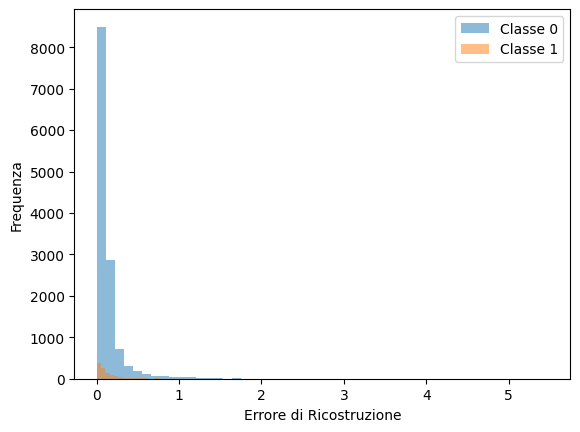

In [21]:
# Distribuzione degli errori di ricostruzione
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.5, label='Classe 0')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.5, label='Classe 1')
plt.legend()
plt.xlabel('Errore di Ricostruzione')
plt.ylabel('Frequenza')
plt.show()

In [22]:
# 5. Valutazione delle performance
auc = roc_auc_score(y_test, reconstruction_error)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

AUC-ROC: 0.5095
Precision: 0.1147
Recall: 0.0719
F1-Score: 0.0884
Confusion Matrix:
[[12355   625]
 [ 1046    81]]


IL MODELLO ATTUALMENTE FA SCHIFO! Possibili miglioramenti:
1) cambiare features considerate (aumentarle?)
2) modificare training e test set?
3) modificare architettura della rete (numero layers, numero neuroni, activation function)
4) cambiare optimizer (ora adam) o learning rate e/o definizione loss
5) cambiare numero di epoche
6) calibrare soglia per definire le anomalie